In [9]:
import matplotlib as mpl
import tensorflow as tf
import os
import time
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers as layers

In [2]:
CLASSES_NUM = 6  # 输出7类地物
LABELS = ['', 'Trees', 'Asphalt', 'Parking lot', 'Bitumen', 'Meadow', 'Soil']
VAL_FRAC = 0.5
TEST_FRAC = 0.3  # target用来测试数据的百分比 test/train
TRAIN_FRAC = 0.7
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
PATIENCE = 15
BUFFER_SIZE = 60000
BATCH_SIZE = 50
BANDS = 72
EPOCHS = 1000
noise_dim = 72
num_examples_to_generate = 16
seed = tf.random.normal([BATCH_SIZE, 72, 1])
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
FEATURE_dim = 36
lr = 4e-4

In [3]:
BANDS = 72
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


class ResBlock(tf.keras.layers.Layer):
    def __init__(self, out_channel):
        super(ResBlock, self).__init__()
        self.c1 = tf.keras.layers.Conv1D(filters=out_channel,
                                         kernel_size=1,
                                         strides=1,
                                         padding='same',
                                         use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.r1 = tf.keras.layers.Activation('tanh')

    def __call__(self, inputs):
        x = inputs
        x = self.c1(x)
        res = x
        x = self.bn1(x)
        x = self.r1(x)
        x += res
        return x


def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7 * 72, use_bias=False, input_shape=(72, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((504, 72)))

    model.add(layers.Conv1D(144, 6, strides=1, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv1D(72, 6, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv1D(36, 6, strides=2, padding='same', use_bias=False, activation='tanh'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(72))
    model.add(layers.Reshape((72, 1)))
    model.add(layers.BatchNormalization())
    return model


def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(72, 7, strides=2, padding='same',
                            input_shape=(72, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv1D(128, 5, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


def make_classifier_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(360, input_shape=(72, 1)))
    model.add(tf.keras.layers.Conv1D(filters=180,
                                     kernel_size=6,
                                     strides=1,
                                     padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool1D(pool_size=3))
    model.add(ResBlock(90))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(ResBlock(90))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(ResBlock(180))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(720))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(360))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(CLASSES_NUM, activation='relu'))
    model.add(tf.keras.layers.LeakyReLU())
    return model


# define losses
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


def encoder_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


def classifier_loss(prediction, label):
    return cross_entropy(label, prediction)


generator_optimizer = tf.optimizers.Adagrad(lr)
discriminator_optimizer = tf.optimizers.Adagrad(lr)
classifier_optimizer = tf.optimizers.Adagrad(lr)


In [4]:
BANDS = 72
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


class ResBlock(tf.keras.layers.Layer):
    def __init__(self, out_channel):
        super(ResBlock, self).__init__()
        self.c1 = tf.keras.layers.Conv1D(filters=out_channel,
                                         kernel_size=1,
                                         strides=1,
                                         padding='same',
                                         use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.r1 = tf.keras.layers.Activation('tanh')

    def __call__(self, inputs):
        x = inputs
        x = self.c1(x)
        res = x
        x = self.bn1(x)
        x = self.r1(x)
        x += res
        return x


def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7 * 72, use_bias=False, input_shape=(72, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((504, 72)))

    model.add(layers.Conv1D(144, 6, strides=1, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv1D(72, 6, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv1D(36, 6, strides=2, padding='same', use_bias=False, activation='tanh'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(72))
    model.add(layers.Reshape((72, 1)))
    model.add(layers.BatchNormalization())
    return model


def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(72, 7, strides=2, padding='same',
                            input_shape=(72, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv1D(128, 5, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


def make_classifier_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(360, input_shape=(72, 1)))
    model.add(tf.keras.layers.Conv1D(filters=180,
                                     kernel_size=6,
                                     strides=1,
                                     padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool1D(pool_size=3))
    model.add(ResBlock(90))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(ResBlock(90))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(ResBlock(180))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(720))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(360))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(CLASSES_NUM, activation='relu'))
    model.add(tf.keras.layers.LeakyReLU())
    return model


# define losses
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


def encoder_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


def classifier_loss(prediction, label):
    return cross_entropy(label, prediction)


generator_optimizer = tf.optimizers.Adagrad(lr)
discriminator_optimizer = tf.optimizers.Adagrad(lr)
classifier_optimizer = tf.optimizers.Adagrad(lr)


In [6]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def gen_dataset_from_dict(file_dict, Val=False):
    data = file_dict['data']
    data = np.transpose(data, (0, 2, 1))
    label = file_dict['gt']
    data_train, data_test, label_train, label_test = train_test_split(data, label, test_size=TEST_FRAC, random_state=42)
    if Val:
        data_test, data_val, label_test, label_val = train_test_split(data_test, label_test, test_size=VAL_FRAC,
                                                                      random_state=43)
    data_train = tf.data.Dataset.from_tensor_slices(data_train)
    data_test = tf.data.Dataset.from_tensor_slices(data_test)
    label_train = tf.data.Dataset.from_tensor_slices(label_train)
    label_test = tf.data.Dataset.from_tensor_slices(label_test)
    if Val:
        data_val = tf.data.Dataset.from_tensor_slices(data_val)
        label_val = tf.data.Dataset.from_tensor_slices(label_val)
        val_ds = tf.data.Dataset.zip((data_val, label_val))
        val_ds = val_ds.map(lambda x, y: {'data': x, 'label': y}).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

    train_ds = tf.data.Dataset.zip((data_train, label_train))
    test_ds = tf.data.Dataset.zip((data_test, label_test))

    train_ds = train_ds.map(lambda x, y: {'data': x, 'label': y}).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    test_ds = test_ds.map(lambda x, y: {'data': x, 'label': y}).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    if Val:
        return train_ds, test_ds, val_ds
    else:
        return train_ds, test_ds


def generate_and_save_Images(model, epoch, test_input):
    """Notice `training` is set to False.
       This is so all layers run in inference mode (batch norm)."""
    """To-do: reshape the curves as they were normalized"""
    prediction = model(test_input, training=False)
    plt.plot(np.arange(72), prediction[0, :, 0])
    plt.savefig('./pics/image_at_{:04d}_epoch.png'.format(epoch))
    plt.show()


def get_data_from_batch(batches):
    return batches['data'], batches['label']


def calculate_acc(target_test_ds,
                  classifier,
                  epoch):
    target_batch = target_test_ds.shuffle(BUFFER_SIZE).as_numpy_iterator().next()
    target_data, target_label = get_data_from_batch(target_batch)
    prediction_t = classifier(target_data, training=False)
    accuracy_t = tf.metrics.Accuracy()
    acc = accuracy_t.result()
    accuracy_t.update_state(y_true=target_label,
                            y_pred=prediction_t)
    print('Target accuracy for epoch {} is'.format(epoch + 1),
          '{}%'.format(accuracy_t.result().numpy() * 100))
    return acc


def plot_acc_loss(acc, gen_loss, disc_loss, cls_loss,
                  generator_loss, discriminator_loss, classifier_loss,
                  source_test_ds, target_test_ds,
                  generator, discriminator, classifier,
                  epoch, gan=True):
    g_loss, d_loss, c_loss, a = [], [], [], []
    for source_test_batch in source_test_ds.as_numpy_iterator():
        for target_test_batch in target_test_ds.as_numpy_iterator():
            X_s, Y_s = get_data_from_batch(source_test_batch)
            X_t, Y_t = get_data_from_batch(target_test_batch)
            generated_target = generator(X_s, training=False)
            real_decision = discriminator(X_t, training=False)
            fake_decision = discriminator(generated_target, training=False)
            prediction = classifier(X_t, training=False)
            accuracy_t = tf.metrics.Accuracy()
            accuracy_t.update_state(y_true=Y_t,
                                    y_pred=prediction)
            a.append(accuracy_t.result().numpy())
            c_loss.append(classifier_loss(prediction, Y_t).numpy())
            g_loss.append(generator_loss(fake_decision).numpy())
            d_loss.append(discriminator_loss(real_decision, fake_decision).numpy())
    a = np.average(a)
    acc.append(a)
    cls_loss.append(np.average(c_loss))
    gen_loss.append(np.average(g_loss))
    disc_loss.append(np.average(d_loss))
    epochs_range = range(epoch+1)

    if gan:
        plt.subplot(1, 1, 1)
        plt.plot(epochs_range, gen_loss, label='Generator_loss')
        plt.plot(epochs_range, disc_loss, label='Discriminator_loss')
        plt.legend(loc='lower right')
        plt.title('Generator and discriminator loss')
    else:
        plt.subplot(1, 1, 1)
        plt.plot(epochs_range, acc, label='Test accuracy')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
    plt.show()
    return acc, gen_loss, disc_loss, cls_loss


In [5]:
# adversarial training block
@tf.function
def GAN_train_step(generator, discriminator,
                   source_batch, target_batch):
    X_s, Y_s = get_data_from_batch(source_batch)
    X_t, Y_t = get_data_from_batch(target_batch)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_target = generator(X_s, training=True)
        fake_decision = discriminator(generated_target, training=True)
        real_decision = discriminator(X_t, training=True)

        gen_loss = generator_loss(fake_decision)
        disc_loss = discriminator_loss(real_decision, fake_decision)

        gen_gradient = gen_tape.gradient(gen_loss, generator.trainable_variables)
        disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gen_gradient,
                                                generator.trainable_variables))
        discriminator_optimizer.apply_gradients((zip(disc_gradient,
                                                     discriminator.trainable_variables)))


@tf.function
def classify_train_step(generator, classifier,
                        source_batch, target_batch):
    X_s, Y_s = get_data_from_batch(source_batch)
    X_t, Y_t = get_data_from_batch(target_batch)
    X_s = generator(X_s, training=False)

    with tf.GradientTape() as cls_tape:
        prediction = classifier(X_t, training=True)
        pred_loss = classifier_loss(prediction, Y_t)
        prediction2 = classifier(X_s, training=True)
        pred_loss += classifier_loss(prediction2, Y_s)

        pred_gradient = cls_tape.gradient(pred_loss, classifier.trainable_variables)
        classifier_optimizer.apply_gradients(zip(pred_gradient,
                                                 classifier.trainable_variables))


def train(generator, discriminator, classifier,
          source_ds, target_ds,
          source_test_ds,
          target_test_ds,
          epochs):
    acc = []
    gen_loss = []
    disc_loss = []
    cls_loss = []
    for epoch in range(epochs):
        start = time.time()
        for source_batch in source_ds.as_numpy_iterator():
            for target_batch in target_ds.as_numpy_iterator():
                GAN_train_step(generator, discriminator,
                               source_batch, target_batch)
        duration = time.time() - start
        print('duration for epoch {} is {}s'.format(epoch + 1, duration))
        acc, gen_loss, disc_loss, cls_loss = plot_acc_loss(acc, gen_loss, disc_loss, cls_loss,
                                                           generator_loss, discriminator_loss, classifier_loss,
                                                           source_test_ds, target_test_ds,
                                                           generator, discriminator, classifier,
                                                           epoch)
        if epoch % 15 == 0:
            generate_and_save_Images(generator, epoch,
                                     source_ds.as_numpy_iterator().next()['data'])
    patience = PATIENCE
    wait = 0
    best = 0
    for epoch in range(epochs):
        for source_batch in source_ds.as_numpy_iterator():
            for target_batch in target_ds.as_numpy_iterator():
                classify_train_step(generator, classifier,
                                    source_batch, target_batch)
        acc, gen_loss, disc_loss, cls_loss = plot_acc_loss(acc, gen_loss, disc_loss, cls_loss,
                                                           generator_loss, discriminator_loss, classifier_loss,
                                                           source_test_ds, target_test_ds,
                                                           generator, discriminator, classifier,
                                                           EPOCHS + epoch, gan=False)
        train_acc = calculate_acc(target_test_ds, classifier, epoch)
        if epoch >= 0:
            wait += 1
            if train_acc > best:
                best = train_acc
                wait = 0
            if wait >= patience:
                break


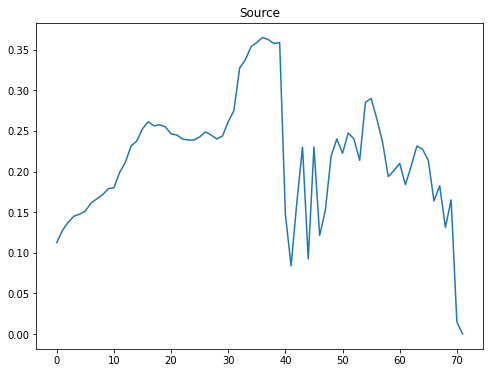

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
"""load data"""
source_dict = sio.loadmat('/content/Source.mat')
source_train_ds, source_test_ds = gen_dataset_from_dict(source_dict)
target_dict = sio.loadmat('/content/Target.mat')
target_train_ds, target_test_ds, target_val_ds = gen_dataset_from_dict(target_dict, Val=True)

plt.plot(np.arange(72), source_train_ds.as_numpy_iterator().next()['data'][0, :, 0])
plt.title('Source')
plt.show()

generator = make_generator_model()
discriminator = make_discriminator_model()
classifier = make_classifier_model()

train(generator, discriminator, classifier,
      source_train_ds, target_train_ds,
      source_test_ds, target_test_ds,
      EPOCHS)

val_accuracy = tf.keras.metrics.CategoricalAccuracy('val_accuracy')
acc = []
for HSI in target_val_ds.as_numpy_iterator():
    data = HSI['data']
    classify_output = classifier(data)
    print(classifier_loss(classify_output, HSI['label']))
    val_accuracy(HSI['label'], classify_output)
    acc.append(val_accuracy.result())
print('whole val acc:{:.2f}%'.format(np.average(acc)*100))
